## Preliminaries

In [1]:
import numpy as np
import torch
import pickle
from tqdm import tqdm
from joblib import Parallel, delayed
from pyro.distributions.empirical import Empirical

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils
from sbi import analysis

# distances
from scipy.spatial.distance import directed_hausdorff
from torch.nn.functional import normalize

In [2]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Simulator

In [3]:
from HH_helper_functions import syn_current

I, t_on, t_off, dt, t, A_soma = syn_current()

In [4]:
from HH_helper_functions import HHsimulator

In [5]:
def run_HH_model(params):

    params = np.asarray(params)
    
    # input current, time step
    I, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I), 1)*dt

    # initial voltage
    V0 = -70
    
    states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

In [6]:
# three sets of (g_Na, g_K)
params = np.array([[50., 1.],[4., 1.5],[20., 15.]])

num_samples = len(params[:,0])
sim_samples = np.zeros((num_samples, len(I)))
for i in range(num_samples):
    sim_samples[i,:] = run_HH_model(params=params[i,:])['data']

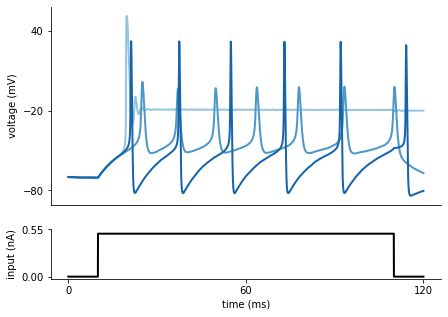

In [7]:
# colors for traces
col_min = 2
num_colors = num_samples+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_samples):
    plt.plot(t,sim_samples[i,:],color=col1[i],lw=2)
plt.ylabel('voltage (mV)')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t,I*A_soma*1e3,'k', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, max(t)/2, max(t)])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
plt.show()

In [8]:
from HH_helper_functions import calculate_summary_statistics

In [9]:
def simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    
    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

In [10]:
true_params = np.array([50., 5.])
labels_params = [r'$g_{Na}$', r'$g_{K}$']
observation_trace = run_HH_model(true_params)
observation_summary_statistics = calculate_summary_statistics(observation_trace)

In [11]:
prior_min = [.5,1e-4]
prior_max = [80.,15.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

## Distance functions

In [12]:
def euclidean(x,y):
    #return torch.linalg.norm(x-y)
    x = torch.tensor(x['data'])
    y = torch.tensor(y['data'])
    return torch.linalg.norm(x-y)

def simulation_wrapper_euclidean(params):
    """
    Uses euclidean distances from a given observation as summary
    """
    obs = observation_trace
    data = run_HH_model(params)
    summstats = euclidean(data,obs)
    return torch.as_tensor([summstats])

In [13]:
def hausdorff_dist(x,y, reverse = False):
    x_pairs = np.array([x['time'],x['data']]).T
    y_pairs = np.array([y['time'],y['data']]).T
    if reverse:
        return directed_hausdorff(y_pairs,x_pairs)
    return directed_hausdorff(x_pairs,y_pairs)
    # x_pairs = torch.vstack([x['time'],x['data']])


In [14]:
def simulation_wrapper_hausdorff(params, reverse=False):
    obs = observation_trace
    data = run_HH_model(params)
    summstats = hausdorff_dist(data,obs, reverse)
    return torch.as_tensor([summstats[0]])

## Define the grid

Define a square grid, equally spaced in the prior

In [15]:
prior_width = torch.tensor(prior_max)-torch.tensor(prior_min)

In [16]:
def theta_grid(num_x, num_y):
    
    x_coords = torch.linspace(prior_min[0], prior_max[0], num_x+2)[1:-1]
    y_coords = torch.linspace(prior_min[1], prior_max[1], num_y+2)[1:-1]

    return torch.cartesian_prod(x_coords, y_coords)


In [17]:
full_grid = theta_grid(8,8)
data = []
for theta in full_grid:
    data.append(run_HH_model(theta)['data'])

time = observation_trace['time']

In [30]:
def grid_hausdorff_score(params):
    input = run_HH_model(params)
    distances = []
    for array in data:
        aug_data = {'time':time, 'data':array}
        distances.append(torch.tensor(hausdorff_dist(input,aug_data)[0]))
    return torch.tensor(distances)


In [19]:
ref_score = grid_hausdorff_score(true_params)

In [20]:
posterior=infer(grid_hausdorff_score, prior, method='SNPE', 
                  num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 143 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

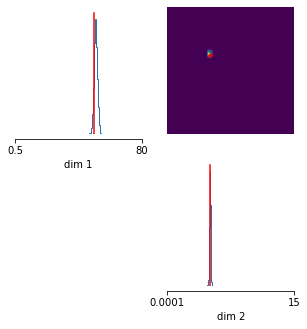

In [21]:
samples = posterior.sample((10000,),x=ref_score)
fig, axes = analysis.pairplot(samples,
                        limits=[[.5,80], [1e-4,15.]],
                        ticks=[[.5,80], [1e-4,15.]],
                        figsize=(5,5),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

In [22]:
posterior=infer(grid_hausdorff_score, prior, method='SNPE', 
                  num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Neural network successfully converged after 354 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

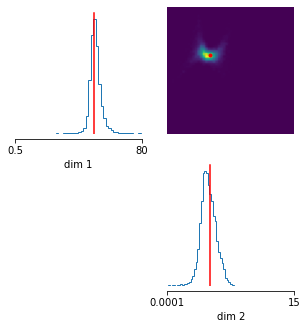

In [25]:
samples = posterior.sample((10000,),x=ref_score)
fig, axes = analysis.pairplot(samples,
                        limits=[[.5,80], [1e-4,15.]],
                        ticks=[[.5,80], [1e-4,15.]],
                        figsize=(5,5),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

## Comparisons with their plots

In [54]:
input = observation_trace
distances = []
for array in data:
    aug_data = {'time':time, 'data':array}
    distances.append(euclidean(input,aug_data))

ref_grid = torch.tensor(distances)

In [55]:
posterior=infer(grid_hausdorff_score, prior, method='SNPE', 
                  num_simulations=60, num_workers=4)

Running 60 simulations in 60 batches.:   0%|          | 0/60 [00:00<?, ?it/s]

 Neural network successfully converged after 171 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

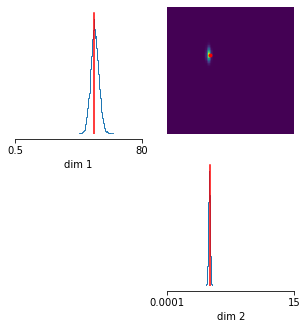

In [56]:
samples = posterior.sample((10000,),x=ref_score)
fig, axes = analysis.pairplot(samples,
                        limits=[[.5,80], [1e-4,15.]],
                        ticks=[[.5,80], [1e-4,15.]],
                        figsize=(5,5),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

In [57]:
posterior_theirs=infer(simulation_wrapper, prior, method='SNPE', 
                  num_simulations=60, num_workers=4)

Running 60 simulations in 60 batches.:   0%|          | 0/60 [00:00<?, ?it/s]

 Neural network successfully converged after 250 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

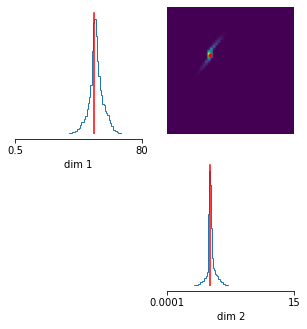

In [59]:
samples = posterior_theirs.sample((10000,),x=observation_summary_statistics)
fig, axes = analysis.pairplot(samples,
                        limits=[[.5,80], [1e-4,15.]],
                        ticks=[[.5,80], [1e-4,15.]],
                        figsize=(5,5),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

In [60]:
def summaries_for_plots(samples):
    all_summs = np.array([simulation_wrapper(sample).numpy() for sample in tqdm(samples)])
    return all_summs

In [61]:
their_samples = posterior_theirs.sample((1000,),x=observation_summary_statistics)
all_summs = summaries_for_plots(their_samples)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [38:11<00:00,  2.29s/it] 


In [63]:
our_samples = posterior.sample((1000,),x=ref_score)
all_summs_h = summaries_for_plots(our_samples)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [20:17<00:00,  1.22s/it]


In [64]:
def MSE(samples, true_params):
    samples = torch.tensor(samples)
    true_params = torch.tensor(true_params)
    loss = torch.nn.MSELoss()
    return loss(samples, true_params)

In [65]:
def plot_from_summaries(all_summs, all_summs_h, x):
    # all_summs=Parallel(n_jobs=7, verbose=10)(simulation_wrapper(sample) for sample in samples)
    # all_summs=np.array([summaries.numpy() for summaries in all_sums])
    plt_titles = ['n_spike', 'rp_mean', 'rp_std','mom_1','mom_2','mom_3','mom_4']
    for i in range(7):
        all_summs_combined = np.concatenate([all_summs, all_summs_h])
        bins_min = min(all_summs_combined[:,i])
        bins_max = max(all_summs_combined[:,i])
        bins = np.linspace(bins_min,bins_max,50)
        plt.hist(all_summs[:,i],bins=bins,alpha=0.5)
        plt.hist(all_summs_h[:,i],bins=bins,alpha=0.5)
        plt.title(plt_titles[i])
        plt.axvline(x[i])
        plt.figure()

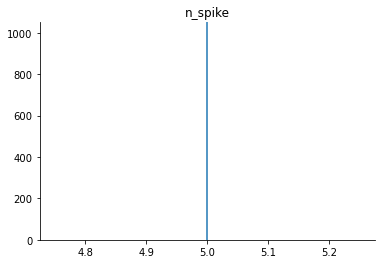

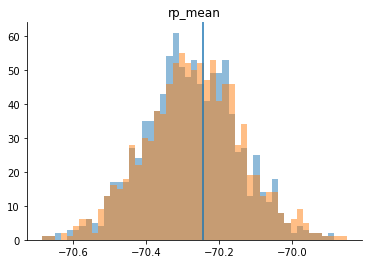

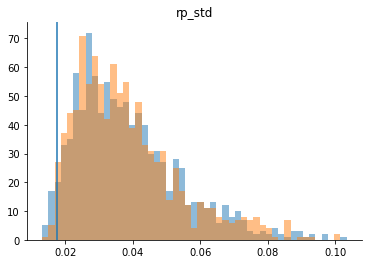

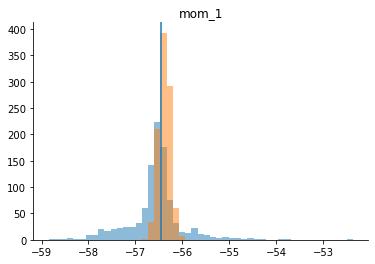

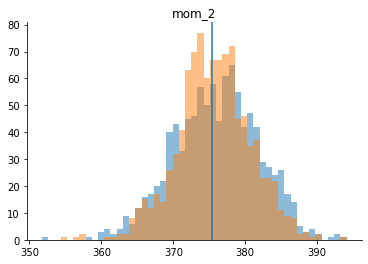

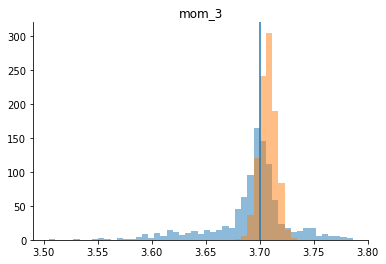

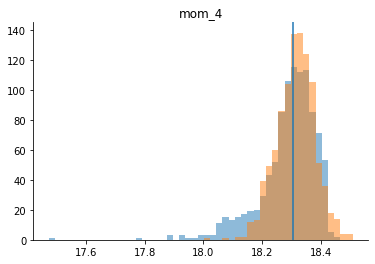

<Figure size 432x288 with 0 Axes>

In [66]:
plot_from_summaries(all_summs, all_summs_h, observation_summary_statistics)

In [69]:
def MSE_plots(all_summs, all_summs_h,x):
    
    def MSE_vector(summs):
        return np.array([MSE(summs[:,i],x[i]) for i in range(7)])

    
    plt_labels = ['n_spike', 'rp_mean', 'rp_std','mom_1','mom_2','mom_3','mom_4']
    label_loc = np.arange(len(plt_labels))
    width = 0.2

    their_MSE_norm = np.ones((7,))
    MSE_h_norm = MSE_vector(all_summs_h)/MSE_vector(all_summs)

    plt.bar(label_loc-0.2, their_MSE_norm, width, color='cyan')
    plt.bar(label_loc, MSE_h_norm, width, color='green')
    plt.xticks(label_loc, plt_labels)
    plt.legend(["Their Posterior", "Hausdorff"])
    plt.show()


/tmp/ipykernel_6913/2837404655.py:12: RuntimeWarning: invalid value encountered in true_divide
  MSE_h_norm = MSE_vector(all_summs_h)/MSE_vector(all_summs)


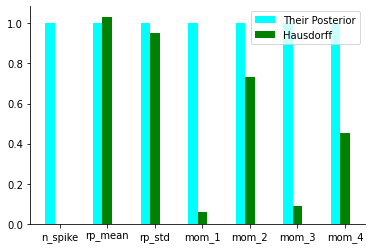

In [70]:
MSE_plots(all_summs, all_summs_h,observation_summary_statistics)

## Euclidean

In [48]:
def grid_euclidean_score(params):
    input = run_HH_model(params)
    distances = []
    for array in data:
        aug_data = {'time':time, 'data':array}
        distances.append(euclidean(input,aug_data))
    return torch.tensor(distances)

In [49]:
ref_e = grid_euclidean_score(true_params)

In [50]:
posterior=infer(grid_euclidean_score, prior, method='SNPE', 
                  num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Neural network successfully converged after 160 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

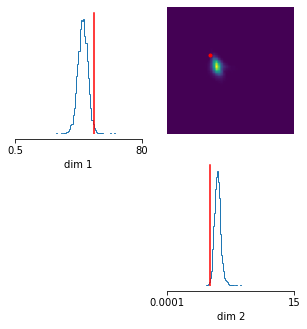

In [52]:
samples = posterior.sample((10000,),x=ref_e)
fig, axes = analysis.pairplot(samples,
                        limits=[[.5,80], [1e-4,15.]],
                        ticks=[[.5,80], [1e-4,15.]],
                        figsize=(5,5),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

In [41]:
def get_grid_euclidean_score_norm(ref):
    norm = torch.linalg.norm(ref)

    def grid_euclidean_score_norm(params):
        input = run_HH_model(params)
        distances = []
        for array in data:
            aug_data = {'time':time, 'data':array}
            distances.append(euclidean(input,aug_data)/norm)
        return torch.tensor(distances)


    return grid_euclidean_score_norm

In [42]:
ref_norm_e = ref_e/torch.linalg.norm(ref_e)
euclidean_score_norm = get_grid_euclidean_score_norm(ref_e)

In [63]:
posterior=infer(euclidean_score_norm, prior, method='SNPE', 
                  num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

Neural network successfully converged after 175 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

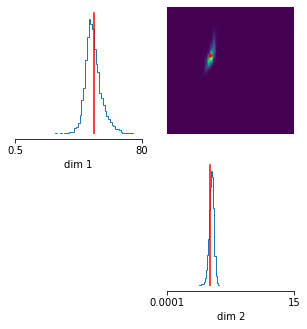

In [76]:
samples = posterior.sample((10000,),x=ref_norm_e)
fig, axes = analysis.pairplot(samples,
                        limits=[[.5,80], [1e-4,15.]],
                        ticks=[[.5,80], [1e-4,15.]],
                        figsize=(5,5),
                        points=[true_params],
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

# Shrinking grid

Rationale: it may be possible to gain more fine-tuned information by having a smaller grid concentrated over the proposal. Of course, this is tricky because it involves changing the actual score function. However, it might not be a fool's errand:

1. We assume some reasonable continuity properties so that if $\theta_1$, $\theta_2$ are close, so too will be $p(x|\theta_1)$ and $p(x|\theta_2)$

2. We iteratively shrink the grid in a way which tries to map $\theta_{i,old}$ to $\theta_{i,new}$ by proximity. Sticking to a grid rather than more complicated distributions of points should simplify this task.

In this case, it could be that network trained on the original grid will be close to one for the new grid.

Question: how do we accomplish the task of mapping from one grid to the other? There are two operations we can enact on the grid, assuming we wish for it to remain a square: we can translate and contract.

In [22]:
def min_phi(new_grid, old_grid):
    """Given two grids, calculates the distance between them according to 
    
    d(G,G') = min_{phi} {M | d(g,g') <= M for all g}

    where phi(g) = g' is a bijection between G,G'.

    then returns the phi which achieves this minimum.

    Naively, all mappings between two grids could be enormous. There are probably some clever algorithms to measure the whole problem but I will skip it for now.

    """
    return



In [23]:
def grid_translate(old_grid, posterior_samples, truncation_param = None):
    
    quantiles = torch.quantile(posterior_samples,torch.tensor([0.05,0.95]),axis=0)
    new_range = quantiles[1]-quantiles[0]
    original_range = old_grid[-1]-old_grid[0]

    scaling = new_range/original_range
    intermediate_grid = old_grid*scaling

    translation = quantiles[0]-intermediate_grid[0]

    new_grid = intermediate_grid+translation

    if truncation_param:
        new_grid = 

        
    return intermediate_grid+translation
    

In [18]:
def get_summary_fun_h(ref_data):

    def grid_hausdorff_score(data):
        distances = []
        aug_input =  {'time':time, 'data':data.numpy()}
        for array in ref_data:
            array = np.array(array)
            aug_data = {'time':time, 'data':array}
            distances.append(torch.tensor(hausdorff_dist(aug_input,aug_data)[0]))
        return torch.tensor(distances)

    def summary_fun_broadcast(data):
        if data.dim() == 1:
            return grid_hausdorff_score(data)
        elif data.dim() == 2:
            scores=[grid_hausdorff_score(vec) for vec in data]
            return torch.stack(scores)

    return summary_fun_broadcast

def full_simulator(params):
    return run_HH_model(params)['data']

Rationale: do only a small amount of training and repeatedly update the grid. In order:

1. Get data from full simulator
2. Fit using summary scores generated by current grid. 
3. Determine new grid from samples from updated proposal and repeat.

In [27]:
# First round init
thetas = theta_grid(8,8)
data = []
for theta in thetas:
    data.append(run_HH_model(theta)['data'])
time = observation_trace['time']
ref_obs = torch.tensor(observation_trace['data'])

Running 60 simulations in 60 batches.:   0%|          | 0/60 [00:00<?, ?it/s]

 Neural network successfully converged after 157 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

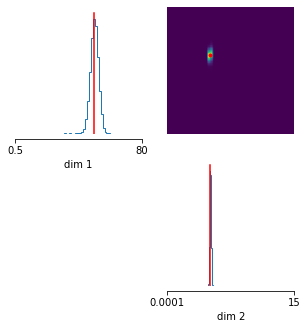

Drawing 60 posterior samples:   0%|          | 0/60 [00:00<?, ?it/s]

Running 60 simulations in 60 batches.:   0%|          | 0/60 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 104 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9959 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


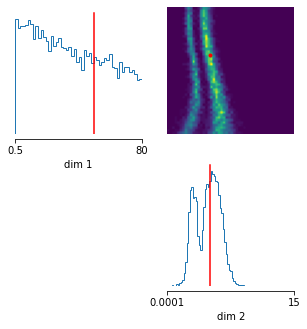

Drawing 60 posterior samples:   0%|          | 0/60 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 8 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 60 simulations in 60 batches.:   0%|          | 0/60 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 68 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9971 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


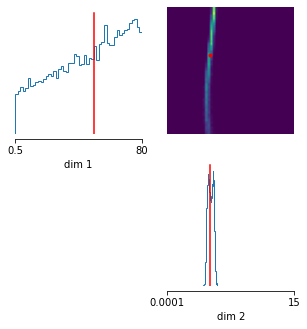

Drawing 60 posterior samples:   0%|          | 0/60 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 44 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 60 simulations in 60 batches.:   0%|          | 0/60 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 77 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

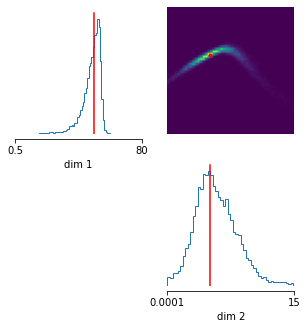

Drawing 60 posterior samples:   0%|          | 0/60 [00:00<?, ?it/s]

Running 60 simulations in 60 batches.:   0%|          | 0/60 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

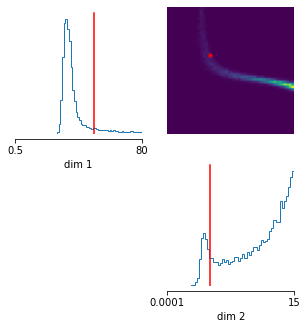

In [31]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(full_simulator, prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    summary_fun = get_summary_fun_h(data)
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=60, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(summary_fun=summary_fun)
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    x_o = summary_fun(ref_obs)
    proposal = posterior.set_default_x(x_o)
    samples = posterior.sample((10000,))
    thetas = grid_translate(thetas,samples)
    # First round init
    data = []
    for theta in thetas:
        data.append(run_HH_model(theta)['data'])
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 440 epochs.ral network. Epochs trained: 37Training neural network. Epochs trained: 205

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

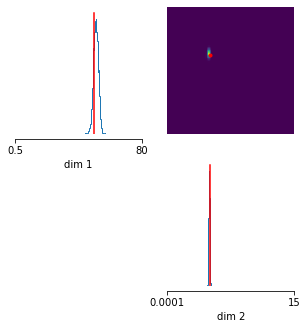

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

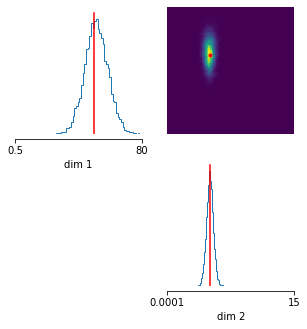

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss


KeyboardInterrupt: 

In [31]:
# First round init
thetas = theta_grid(8,8)
data = []
for theta in thetas:
    data.append(run_HH_model(theta)['data'])
time = observation_trace['time']
ref_obs = torch.tensor(observation_trace['data'])

num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(full_simulator, prior)
proposal = prior
for i in range(num_rounds):
    inference = SNPE(prior=prior)
    summary_fun = get_summary_fun_h(data)
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=100, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(summary_fun=summary_fun)
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    x_o = summary_fun(ref_obs)
    proposal = posterior.set_default_x(x_o)
    samples = posterior.sample((10000,))
    thetas = grid_translate(thetas,samples)
    # First round init
    data = []
    for theta in thetas:
        data.append(run_HH_model(theta)['data'])
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

## Roughs

In [34]:
thetas.mean(axis=0)

tensor([51.2736,  5.0162])

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 117 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

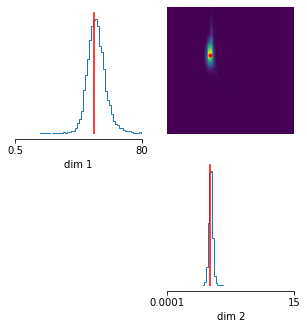

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 55 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

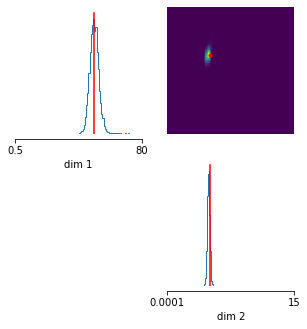

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 58 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

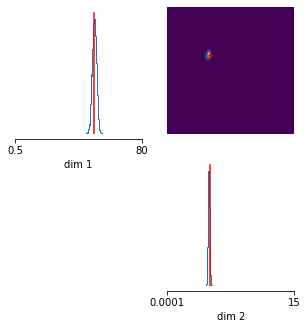

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 43 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

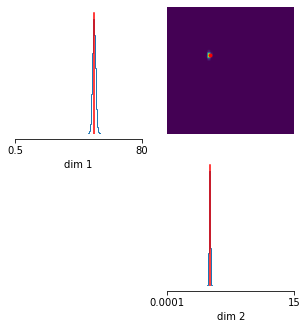

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

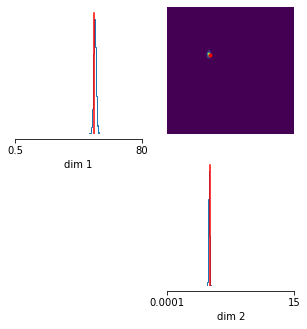

In [44]:
# First round init
thetas = theta_grid(8,8)
data = []
for theta in thetas:
    data.append(run_HH_model(theta)['data'])
time = observation_trace['time']
ref_obs = torch.tensor(observation_trace['data'])

num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(full_simulator, prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    summary_fun = get_summary_fun_h(data)
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=100, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(summary_fun=summary_fun)
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    x_o = summary_fun(ref_obs)
    proposal = posterior.set_default_x(x_o)
    samples = posterior.sample((10000,))
    #thetas = thetas.mean(axis=0).reshape(1,2)
    # First round init
    # data = []
    # for theta in thetas:
    #     data.append(run_HH_model(theta)['data'])
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

 Neural network successfully converged after 148 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

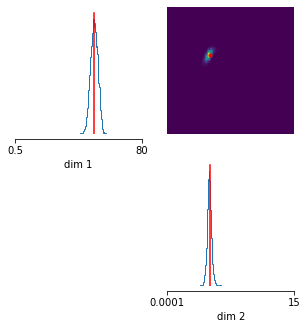

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 92 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

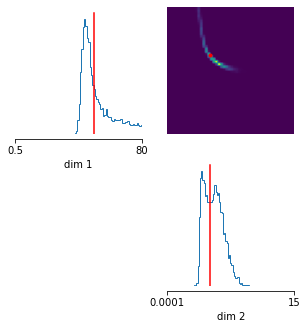

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 84 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

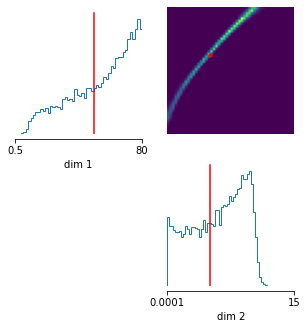

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [45]:
# First round init
thetas = theta_grid(8,8)
data = []
for theta in thetas:
    data.append(run_HH_model(theta)['data'])
time = observation_trace['time']
ref_obs = torch.tensor(observation_trace['data'])

num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(full_simulator, prior)
proposal = prior
for i in range(num_rounds):
    inference = SNPE(prior=prior)
    summary_fun = get_summary_fun_h(data)
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=100, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(summary_fun=summary_fun)
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    x_o = summary_fun(ref_obs)
    proposal = posterior.set_default_x(x_o)
    samples = posterior.sample((10000,))
    #thetas = thetas.mean(axis=0).reshape(1,2)
    # First round init
    # data = []
    # for theta in thetas:
    #     data.append(run_HH_model(theta)['data'])
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbi/sbi/inference/snpe/snpe_base.py:534: UserWarning: The proposal you passed is neither the prior nor a `NeuralPosterior` object. If you are an expert user and did so for research purposes, this is fine. If not, you might be doing something wrong: feel free to create an issue on Github.
  warn(


Using SNPE-C with atomic loss
 Neural network successfully converged after 113 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

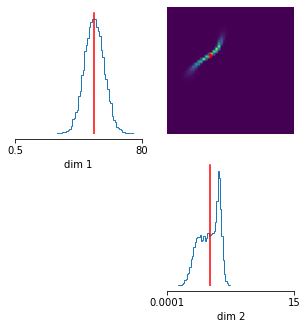

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 58 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

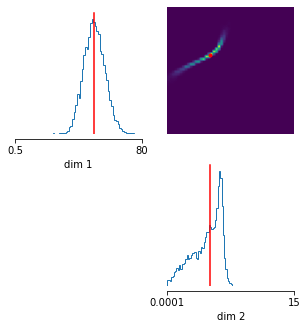

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

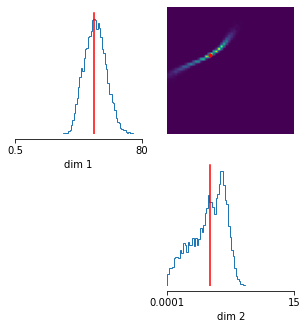

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss


KeyboardInterrupt: 

In [21]:
# First round init
# test_prior_min = [48.,4.]
# test_prior_max = [52.,6]
# test_prior = utils.torchutils.BoxUniform(low=torch.as_tensor(test_prior_min), 
#                                     high=torch.as_tensor(test_prior_max))
                                    
# def theta_grid_2(x_min, x_max, num_x, y_min, y_max, num_y):
    
#     x_coords = torch.linspace(x_min, x_max, num_x+2)[1:-1]
#     y_coords = torch.linspace(y_min, y_max, num_y+2)[1:-1]

#     return torch.cartesian_prod(x_coords, y_coords)

# thetas = theta_grid_2(test_prior_min[0],test_prior_max[1],8,test_prior_min[1],test_prior_max[1],8)

# data = []
# for theta in thetas:
#     data.append(run_HH_model(theta)['data'])
# time = observation_trace['time']
# ref_obs = torch.tensor(observation_trace['data'])

num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(full_simulator, prior)
proposal = test_prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    summary_fun = get_summary_fun_h(data)
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=100, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(summary_fun=summary_fun)
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    x_o = summary_fun(ref_obs)
    proposal = posterior.set_default_x(x_o)
    samples = posterior.sample((10000,))
    #thetas = thetas.mean(axis=0).reshape(1,2)
    # First round init
    # data = []
    # for theta in thetas:
    #     data.append(run_HH_model(theta)['data'])
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

In [22]:
posterior_test = posterior=infer(grid_hausdorff_score, prior, method='SNPE', 
                  num_simulations=100, num_workers=4)

NameError: name 'grid_hausdorff_score' is not defined

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 122 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

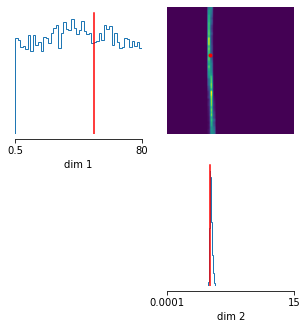

In [45]:
inference = SNPE(prior=prior)
summary_fun = get_summary_fun_h(data)
theta, x = simulate_for_sbi(simulator, prior, num_simulations=300, num_workers=7)
density_estimator = inference.append_simulations(theta, x, proposal=prior).train(summary_fun=summary_fun)
posterior_test = inference.build_posterior(density_estimator)
x_o = summary_fun(ref_obs)
posterior_test = posterior_test.set_default_x(x_o)
samples = posterior_test.sample((10000,))
#thetas = thetas.mean(axis=0).reshape(1,2)
# First round init
# data = []
# for theta in thetas:
#     data.append(run_HH_model(theta)['data'])
fig, axes = analysis.pairplot(samples,
                        limits=[[.5,80], [1e-4,15.]],
                        ticks=[[.5,80], [1e-4,15.]],
                        figsize=(5,5),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

In [38]:
samples.max(axis=0)

torch.return_types.max(
values=tensor([51.5283,  5.9638]),
indices=tensor([6014, 3591]))

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

/home/sragy/sb_inference/sbi/sbi/inference/snpe/snpe_base.py:534: UserWarning: The proposal you passed is neither the prior nor a `NeuralPosterior` object. If you are an expert user and did so for research purposes, this is fine. If not, you might be doing something wrong: feel free to create an issue on Github.
  warn(


Using SNPE-C with atomic loss
 Neural network successfully converged after 59 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

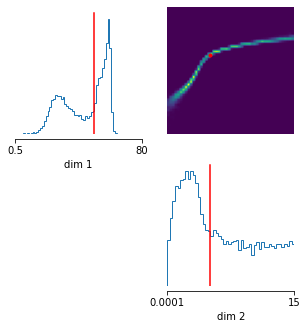

In [44]:
inference = SNPE(prior=prior)
summary_fun = get_summary_fun_h(data)
theta, x = simulate_for_sbi(simulator, test_prior, num_simulations=200, num_workers=7)
density_estimator = inference.append_simulations(theta, x, proposal=test_prior).train(summary_fun=summary_fun)
posterior_test = inference.build_posterior(density_estimator)
x_o = summary_fun(ref_obs)
posterior_test = posterior_test.set_default_x(x_o)
samples = posterior_test.sample((10000,))
#thetas = thetas.mean(axis=0).reshape(1,2)
# First round init
# data = []
# for theta in thetas:
#     data.append(run_HH_model(theta)['data'])
fig, axes = analysis.pairplot(samples,
                        limits=[[.5,80], [1e-4,15.]],
                        ticks=[[.5,80], [1e-4,15.]],
                        figsize=(5,5),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()